# Alberi decisonali e Foreste casuali
In questo tutorial utilizzeremo **alberi decisionali (dall'inglese Decision Tree)** e **foreste casuali (dall'inglese Random Forest)** per creare un modello di machine learning in grado di dirci se una determinata persona avrebbe avuto possibilità di salvarsi dal disastro del Titanic.<br>
Importiamo le librerie necessarie

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

Carichiamo il dataset dal sito della Standford University

In [128]:
titanic = pd.read_csv("http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv")
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
Survived                   887 non-null int64
Pclass                     887 non-null int64
Name                       887 non-null object
Sex                        887 non-null object
Age                        887 non-null float64
Siblings/Spouses Aboard    887 non-null int64
Parents/Children Aboard    887 non-null int64
Fare                       887 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.5+ KB


Il dataset contiene 887 esempi e 8 colonne, la colonna target è <span style="font-family: Monaco">Survived</span>, che contiene 1 nel caso in cui un utente si sia salvato, 0 altrimenti.
<span style="font-family: Monaco">Pclass</span> e <span style="font-family: Monaco">Fare</span> sono proprietà interessanti, in quanto mostrano rispettivamente la classe di viaggio e il costo del biglietto per il Titanic.<br>
La colonna Name contiene il nome del passeggero ed è ininfluente per il nostro semplice modello, quindi scartiamola

In [129]:
titanic = titanic.drop("Name",axis=1)

Eseguiamo il One Hot Encoding del DataFrame per dividere uomo/donna in due colonne diverse.

In [130]:
titanic = pd.get_dummies(titanic)
titanic.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


Adesso possiamo creare i nostri array Numpy per addestramento e test.

In [131]:
X = titanic.drop("Survived", axis=1).values
Y = titanic["Survived"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train.shape

(620, 7)

Un vantaggio degli alberi decisionali è che non richiedono che i dati siano sulla stessa scala, quindi possiamo proseguire direttamente a creare il nostro modello.

In [132]:
def plot_confusion_matrix(label_test, predizioni):
    from seaborn import heatmap
    from matplotlib import pyplot as plt
    from sklearn.metrics import confusion_matrix, accuracy_score
    et = list(sorted(set(label_test)))
    conf_matrix = pd.DataFrame(confusion_matrix(label_test, predizioni),
                               index=et, columns=et)
    # Normalizzazione
    conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
    heatmap(conf_matrix, annot=True, annot_kws={"size": 20}, square=True)
    score = accuracy_score(label_test, predizioni)
    plt.title("Accuracy: {:0.3f}".format(score))
    plt.xlabel("Predicted label", {"weight": "bold", "size": "large"})
    plt.ylabel("True label", {"weight": "bold", "size": "large"})
    plt.xticks(rotation=45, size=12)
    plt.yticks(rotation=0, size=12)

## Alberi decisionali
Un'albero decisionale è un modello di machine learning che permette di eseguire predizioni apprendendo una sequenza di domande dai dati.<br>
Creiamo il nostro albero decisionale utilizzando scikit-learn e calcoliamo l'accuratezza della classificazione su train e test set.

In [133]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="gini") #gini è il valore di default, quindi potremmo anche omettere il parametro
tree.fit(X_train, Y_train)

y_pred_train = tree.predict(X_train)
y_pred = tree.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.9806 TEST=0.7903


              precision    recall  f1-score   support

           0       0.84      0.81      0.82       162
           1       0.72      0.76      0.74       105

   micro avg       0.79      0.79      0.79       267
   macro avg       0.78      0.79      0.78       267
weighted avg       0.79      0.79      0.79       267



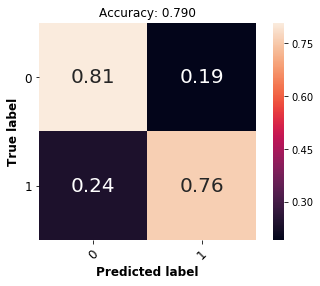

In [134]:
from sklearn.metrics import classification_report
plot_confusion_matrix(Y_test, y_pred)
print(classification_report(Y_test, y_pred))

Il nostro albero decisionale soffre di un problema di overfitting, dovuto probabilmente alla sua eccessiva profondità, tramite il parametro max_depth possiamo controllarne la profondità massima.

In [135]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, Y_train)

y_pred_train = tree.predict(X_train)
y_pred = tree.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.8935 TEST=0.8202


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       162
           1       0.81      0.70      0.76       105

   micro avg       0.82      0.82      0.82       267
   macro avg       0.82      0.80      0.81       267
weighted avg       0.82      0.82      0.82       267



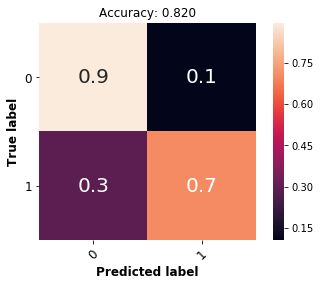

In [136]:
from sklearn.metrics import classification_report
plot_confusion_matrix(Y_test, y_pred)
print(classification_report(Y_test, y_pred))

Visualizziamo e plottiamo ora le features in base alla loro rilevanza

In [137]:
importances = tree.feature_importances_
indices = list(np.argsort(importances))[::-1]
indices

[5, 4, 0, 1, 2, 3, 6]

In [138]:
# Ranking delle features
print("Feature ranking:")
for count, f in enumerate(indices):
    print("{0}. feature {1} ({2})".format(count+1, f, importances[f]))

Feature ranking:
1. feature 5 (0.4768114739648626)
2. feature 4 (0.17246661527273774)
3. feature 0 (0.14747704264825118)
4. feature 1 (0.1471950740827224)
5. feature 2 (0.04374997101323414)
6. feature 3 (0.012299823018191991)
7. feature 6 (0.0)


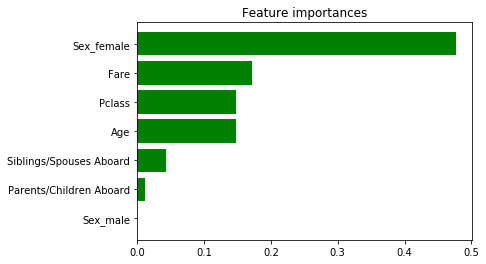

In [144]:
# Plotta le feature più importanti in ordine
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), titanic.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

Un'altra caratteristica fantastica degli alberi decisionali è che possono essere visualizzati.
Utilizziamo la funzione export_graphviz di scikit-learn per esportare l'albero in un file dot.

In [140]:
from sklearn.tree import export_graphviz

dotfile = open("tree.dot", 'w')
export_graphviz(tree, out_file = dotfile, feature_names = titanic.columns.drop("Survived"))
dotfile.close()

Adesso prova ad apire il file con il programma Graphviz, oppure se non lo hai e non vuoi installarlo incolla il contenuto del file in [questo sito](http://webgraphviz.com/)<br>
Dovresti ottenere qualcosa del genere.
<img src="https://github.com/ProfAI/ml00/blob/master/6%20-%20Modelli%20di%20classificazioni%20non%20lineari/res/tree.png?raw=1"/>

## Foreste casuali
Le foresti casuali sono un modello appartenente alla categoria degli **Esemble Method (modelli di insieme)**, esse permettono di creare diversi alberi decisionali e metterli insieme per ottenere un modello più robusto.<br>
Creiamo la nostra foresta casuale utilizzando scikit-learn e calcoliamo l'accuratezza delle classificazioni su train e test set.

In [141]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=False)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.9161 TEST=0.8577


Il risultato così ottenuto è decisamente migliore rispetto a quanto abbiamo ottenuto con un unico albero.